In [10]:
import numpy as np

# fourier number for my aluminum
def Fourier(alpha=0.0000097, t=0.001, L=0.001):
    return alpha*t/L**2


SF = np.sqrt(Fourier())

print(SF)

0.09848857801796106


  0%|          | 0/1000000 [00:00<?, ?it/s]

100%|██████████| 1000000/1000000 [00:31<00:00, 32075.72it/s]


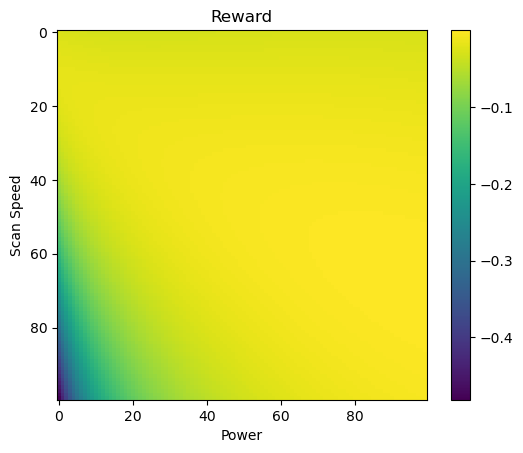

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


class QLearning:
    def __init__(self):
        # my hyperparameters
        self.alpha = 0.9
        self.gamma = 0.6
        self.epsilon = 0.1
        self.start_reward = -1
        self.lr = 0.1
        #self.q_table = np.zeros((100, 100, 4))
        self.power_range = np.linspace(50.0, 400.0, 100)
        self.scan_speed_range = np.linspace(0.3, 3.0, 100)
        self.q_table = np.zeros((self.power_range.size, self.scan_speed_range.size, 4))
        self.epochs = 1000000
        # material properties and constants from papers
        self.absorptivity = 0.3
        self.rho = 2500.0
        self.Cp = 915.0
        self.T_solid = 853.0
        self.T_0 = 300.0
        self.hf = 40000.0
        self.Diffusivity = 0.000097
        self.beam_diameter = 0.0001

    # dimentionless enthalpy function
    def H_star(self, power, scan_speed):
        H = ((4 * self.absorptivity * power ) / (np.pi * self.rho * (self.Cp * (self.T_solid - self.T_0) + self.hf) * np.sqrt(self.Diffusivity * (scan_speed) * self.beam_diameter**3)))
        return H
    
    def reward(self, power, scan_speed):
        
        # normalised reward function
        # the aim is to get melt pool depth of 120 micrometers
        # to fix the main problem of aditive manufactuing the higher speed the better
        # the multiplication by 0.3 is absorbtivity
        # 0.9 is the fourier number for my Alu
        # 100 is to get the correct units
        # this is based on the dimentionless enthalpy paper, the absorbtivity paper, and the melt pool paper
        # min max normalisation to get -1 to 0
        # -36000 is the min reward
        # 0 is the max reward
        reward = (-((self.H_star(power, scan_speed)* 0.3*0.9*100)-130)**2 - 1000*((scan_speed - 3)**2))/400000
        #print(power, scan_speed, reward)
        return reward
    
    def get_state(self, power, scan_speed):
        power_index = np.argmin(np.abs(self.power_range - power))
        scan_speed_index = np.argmin(np.abs(self.scan_speed_range - scan_speed))
        return power_index, scan_speed_index
    
    # pick action based on epsilon greedy policy
    def get_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            action = np.random.choice(4)
            #print(action)
        else:
            # action = int((np.random.uniform(0, 1))*4)
            # print(action)
            action = np.argmax(self.q_table[state])
        return action
    
    # update q table
    def update_q_table(self, state, action, reward, next_state):
        predict = self.q_table[state][action]
        target = reward + self.gamma * np.max(self.q_table[next_state])
        self.q_table[state][action] += self.alpha * (target - predict)

    # train the agent
    def train(self):
        # start reward is set to a big negative number
        reward = self.start_reward

        for epoch in tqdm(range(self.epochs)):
            power = np.random.choice(self.power_range)
            scan_speed = np.random.choice(self.scan_speed_range)
            state = self.get_state(power, scan_speed)
            action = self.get_action(state)
            
            # manual clipping of the reward to avoid div by 0 arythmetic of very small numbers 
            # when using this setting you will end up with bigger problems than porosity according to papers so they might as well be ignored
            if power < 50 or scan_speed < 0.2:
                reward = -1
            else:
                #reward = self.reward(power, scan_speed)
                reward = (self.reward(power, scan_speed)*(1-self.lr) + (self.lr)*reward)

            if action == 0:
                power = min(power + 1, self.power_range[-1])
            elif action == 1:
                power = max(power - 1, self.power_range[0])
            elif action == 2:
                scan_speed = min(scan_speed + 0.1, self.scan_speed_range[-1])
            elif action == 3:
                scan_speed = max(scan_speed - 0.1, self.scan_speed_range[0])
            next_state = self.get_state(power, scan_speed)
            self.update_q_table(state, action, reward, next_state)

        return self.q_table
    
    def optimal_policy(self):
        optimal_policy = np.zeros((self.power_range.size, self.scan_speed_range.size))
        for i in range(self.power_range.size):
            for j in range(self.scan_speed_range.size):
                optimal_policy[i][j] = np.argmax(self.q_table[i][j])
        return optimal_policy
    
    # plots
    def plot_optimal_policy(self):
        optimal_policy = self.optimal_policy()
        plt.imshow(optimal_policy)
        plt.colorbar()
        plt.xlabel('Power / 4')
        plt.ylabel('Scan Speed * 33')
        plt.title('Optimal Policy')
        plt.show()

    def plot_reward(self):
        reward = np.zeros((self.power_range.size, self.scan_speed_range.size))
        for i in range(self.power_range.size):
            for j in range(self.scan_speed_range.size):
                reward[i][j] = self.reward(self.power_range[i], self.scan_speed_range[j])
        plt.imshow(reward)
        plt.colorbar()
        plt.xlabel('Power')
        plt.ylabel('Scan Speed')
        plt.title('Reward')
        plt.show()

ql = QLearning()
q_table = ql.train()
# #ql.plot_optimal_policy()
ql.plot_reward()







In [12]:
# # print the values assossiated with the highest reward
# print(np.max(q_table))

# # print the power and scan speed values assossiated with the highest reward
# print(np.argmax(q_table))
q_copy = q_table.copy()

#location of the highest reward
recc_power, recc_ss, R = np.unravel_index(np.argmax(q_copy, axis=None), q_copy.shape)
print(f"The recommended power is {recc_power*4} and the recommended scan speed is {recc_ss/33:.2f}")
#location of the second highest reward
q_copy[recc_power, recc_ss] = -1000000
recc_power, recc_ss, R = np.unravel_index(np.argmax(q_copy, axis=None), q_copy.shape)
print(f"The second recommended power is {recc_power*4} and the second recommended scan speed is {recc_ss/33:.2f}")
#location of the third highest reward
q_copy[recc_power, recc_ss] = -1000000
recc_power, recc_ss, R = np.unravel_index(np.argmax(q_copy, axis=None), q_copy.shape)
print(f"The third recommended power is {recc_power*4} and the third recommended scan speed is {recc_ss/33:.2f}")

# highest reward
print(np.max(q_table))
print(np.min(q_table))

The recommended power is 284 and the recommended scan speed is 3.00
The second recommended power is 284 and the second recommended scan speed is 2.88
The third recommended power is 256 and the third recommended scan speed is 2.67
-0.002378520143505793
-0.8881474949578902


In [13]:
# save the q table and the optimal policy as a tiff file
import tifffile as tiff

tiff.imwrite('q_table.tiff', q_table)
tiff.imwrite('optimal_policy.tiff', ql.optimal_policy())

print("q_table and optimal_policy saved as tiff files")


q_table and optimal_policy saved as tiff files


/tmp/ipykernel_82359/3772936886.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = df._append({'Power': power, 'Scan Speed': scan_speed, 'H_star': reward}, ignore_index=True)


16.072810378421977


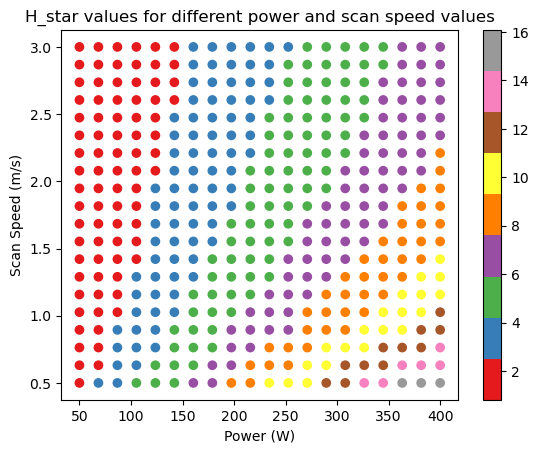

In [14]:
import numpy as np
import math
import pandas as pd
# input material properties

# calcualte alpha

# calcualte teh melt pool depth

# return pi1, pi2 

# heat of fusion for alu is 10.79 kJ/mol ???
# or 4*10^5 J/kg

# t0 will be 300K
# t_solid will be 580 + 273 K = 853 K

# rho = 2700 kg/m^3

# Cp = 0.915 kJ/kgK

# diffusivity = 9.7 * 10^-5 m^2/s

# lets take the absorptivity as 0.3 the same as in the paper
# assume that lasre power is at least 100W set the absorbptivity to 0.4 accoridn to the material paper


# we have: 
# maybe absorptivity, power, rho, cp, T_solid, T_0, hf, Diffusivity, scan_speed, beam_diameter

# ask abou the beam diameter, absorptivity

# we dont have:
# 


def H_star(absorptivity=0.3, power=400.0, rho=2500.0, Cp=915.0, T_solid=853.0, T_0=300.0, hf=40000.0, Diffusivity=0.000097, scan_speed=0.5, beam_diameter=0.0001):

    H = (4 * absorptivity * power)/(np.pi*rho*(Cp*(T_solid - T_0) + hf) * np.sqrt(Diffusivity * scan_speed * beam_diameter**3))

    #write the values for the variables in a csv file 
        

    return H

test_1 = H_star()

print(test_1)



# write a loop to go through power bewtween 50 and 400W, scan speed between 0.750 and 3.0

#H * fourier number * absorptivity

df = pd.DataFrame(columns=['Power', 'Scan Speed', 'H_star'])

for power in np.linspace(50, 400, 20):
    for scan_speed in np.linspace(0.5, 3.0, 20):
        H_star_val = H_star(power=power, scan_speed=scan_speed)
        #*100*0.9*0.3
        # reward = ((-0.1*(H_star_val - 150)**2) - 1000*((scan_speed - 3)**2) - 0.1*(power - 300)**2)
        # making the polot more legible, change for actualy reward function
        reward = H_star_val

        df = df._append({'Power': power, 'Scan Speed': scan_speed, 'H_star': reward}, ignore_index=True)

# print(df)

# write all the values for the variables in a csv file
df.to_csv('H_star_values.csv')


# reward fucntion in terms of just the enthalpy

import matplotlib.pyplot as plt

plt.scatter(df['Power'], df['Scan Speed'], c=df['H_star'], cmap='Set1')
plt.colorbar()
plt.xlabel('Power (W)')
plt.ylabel('Scan Speed (m/s)')
plt.title('H_star values for different power and scan speed values')

        

plt.show()